In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import numpy as np
import json

np.set_printoptions(precision=3, suppress=True)
# uncomment and replace with correct path if there are import errors
# sys.path.append("/path/to/surface-sampling/")
# sys.path.append("/path/to/NeuralForceField/")
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] ="/path/to/lammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from mcmc.system import SurfaceSystem
from mcmc.utils.misc import get_atoms_batch

from time import perf_counter

/home/dux/NeuralForceField/models


Initialize test slab and parameters

In [3]:
# Load prepared pristine slab
element = []
slab_pkl = open("data/SrTiO3_001_2x2_pristine_slab.pkl", "rb")
slab = pickle.load(slab_pkl)
offset_data_path = os.path.join(
    os.getcwd(),
    "data/nff",
    "offset_data.json",
)

system_settings = {
    "surface_name": "SrTiO3(001)",
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.55,
    "no_obtuse_hollow": True,
}

sampling_settings = {
    "alpha": 1.0,  # no annealing
    "temperature": 1.0,  # in terms of kbT
    "num_sweeps": 10,
    "sweep_size": 5,
}

calc_settings = {
    "calc_name": "NFF",
    "optimizer": "BFGS",
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "relax_atoms": True,
    "relax_steps": 20,
    "offset": True,
    "offset_data": json.load(open(offset_data_path, "r")),
}

Obtain adsorption sites

In [4]:
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

pristine_slab = slab.copy()
pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)

ads_positions = site_finder.find_adsorption_sites(
    put_inside=True,
    symm_reduce=False,
    near_reduce=system_settings["near_reduce"],
    distance=system_settings["planar_distance"],
    no_obtuse_hollow=system_settings["no_obtuse_hollow"],
)["all"]

print(f"adsorption coordinates are: {ads_positions[:5]}...")

adsorption coordinates are: [array([ 7.871,  7.941, 18.87 ]), array([ 1.968,  1.951, 18.829]), array([ 1.968,  0.146, 18.782]), array([ 7.871,  3.956, 18.87 ]), array([ 1.968,  5.936, 18.829])]...


Set up NFF (calculator). We are using neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file

In [5]:
import torch
from nff.io.ase_calcs import NeuralFF
from nff.utils.cuda import cuda_devices_sorted_by_free_mem
from mcmc.calculators import EnsembleNFFSurface

if torch.cuda.is_available():
    DEVICE = f"cuda:{cuda_devices_sorted_by_free_mem()[-1]}"
else:
    DEVICE = "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_settings)

offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters
chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


Initialize surface system

In [7]:
slab_batch = get_atoms_batch(
    slab,
    system_settings["cutoff"],
    DEVICE,
    props={"energy": 0, "energy_grad": []},
)

surface = SurfaceSystem(
    slab_batch,
    ads_positions,
    calc=nff_surf_calc,
    surface_depth=1,
    system_settings=system_settings,
)
surface.all_atoms.write("SrTiO3_001_2x2_all_virtual_ads.cif")

2024-06-22 14:35:30,033|INFO|initializing 64 virtual atoms
2024-06-22 14:35:30,068|INFO|initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2024-06-22 14:35:30,069|INFO|number of pristine atoms is 60
2024-06-22 14:35:30,074|INFO|bulk indices are [ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 24 25 26 27
 28 29 30 31 32 33 34 35 36 39 40 41 42 43 44 45 46 47 48 49 50 51 54 55
 56 57 58 59]
2024-06-22 14:35:30,075|INFO|surface indices are [ 7  8 22 23 37 38 52 53]
2024-06-22 14:35:30,076|INFO|constraints are FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58, 59])


      Step     Time          Energy         fmax
BFGS:    0 14:35:31     -467.521881        0.2044
BFGS:    1 14:35:31     -467.525757        0.1803
BFGS:    2 14:35:31     -467.540619        0.0793
BFGS:    3 14:35:31     -467.540924        0.0598
BFGS:    4 14:35:32     -467.541351        0.0059


In [8]:
surface.get_potential_energy()

array([-467.541], dtype=float32)

In [9]:
surface.calc.offset_data

{'bulk_energies': {'O': -0.17747231201,
  'Sr': -0.06043637668,
  'SrTiO3': -1.470008697358702},
 'stoidict': {'Sr': 0.49995161381315867,
  'Ti': -0.0637500349111578,
  'O': -0.31241304903276834,
  'offset': -11.324476454433157},
 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3},
 'ref_formula': 'SrTiO3',
 'ref_element': 'Ti'}

In [10]:
surface.get_surface_energy()

array([12.471], dtype=float32)

Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

2024-06-22 14:35:53,181|INFO|there are 60 atoms in pristine slab
2024-06-22 14:35:53,183|INFO|Running with num_sweeps = 10, temp = 1.0, pot = [-2, 0, 0], alpha = 1.0
2024-06-22 14:35:53,184|INFO|In pristine slab, there are a total of 64 sites


      Step     Time          Energy         fmax
BFGS:    0 14:35:53     -467.521881        0.2044
BFGS:    1 14:35:53     -467.525757        0.1803
BFGS:    2 14:35:53     -467.540619        0.0793
BFGS:    3 14:35:53     -467.540924        0.0598
BFGS:    4 14:35:53     -467.541351        0.0059


2024-06-22 14:35:53,776|INFO|running for 5 iterations per run over a total of 10 runs
2024-06-22 14:35:53,776|INFO|starting with iteration 0
2024-06-22 14:35:53,777|INFO|In sweep 1 out of 10


temp list is:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
      Step     Time          Energy         fmax
BFGS:    0 14:35:53     -470.895508        7.5528
BFGS:    1 14:35:54     -471.755615        4.9144
BFGS:    2 14:35:54     -472.750092        3.0359
BFGS:    3 14:35:54     -473.586548        2.6796
BFGS:    4 14:35:54     -474.004242        2.7264
BFGS:    5 14:35:54     -474.206024        2.3377
BFGS:    6 14:35:54     -474.637451        1.0434
BFGS:    7 14:35:54     -474.924561        1.7334
BFGS:    8 14:35:54     -475.301392        3.0130
BFGS:    9 14:35:54     -475.781952        2.7121
BFGS:   10 14:35:54     -476.194336        1.6167
BFGS:   11 14:35:54     -476.499878        1.3670
BFGS:   12 14:35:55     -476.497589        2.2393
BFGS:   13 14:35:55     -476.668823        1.1866
BFGS:   14 14:35:55     -476.799530        1.0468
BFGS:   15 14:35:55     -476.943237        1.0018
BFGS:   16 14:35:55     -476.976685        0.8247
BFGS:   17 14:35:55     -477.064209        0.8336
BFGS:

2024-06-22 14:36:06,900|INFO|current energy is [12.881], calculated energy is 12.880645751953125
2024-06-22 14:36:06,901|INFO|optim structure has Energy = 12.881+/-0.014
2024-06-22 14:36:06,902|INFO|average force error = 0.066
2024-06-22 14:36:06,912|INFO|In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:36:07     -470.185944       21.2106
BFGS:    1 14:36:07     -473.607666       10.6373
BFGS:    2 14:36:07     -475.817535        6.4143
BFGS:    3 14:36:07     -477.657684        3.8614
BFGS:    4 14:36:07     -478.837738        2.4376
BFGS:    5 14:36:07     -479.508667        1.9483
BFGS:    6 14:36:07     -479.901001        2.6549
BFGS:    7 14:36:07     -480.329620        5.4343
BFGS:    8 14:36:07     -480.775177        2.8163
BFGS:    9 14:36:07     -481.309784        2.0738
BFGS:   10 14:36:07     -481.759277        2.7290
BFGS:   11 14:36:07     -482.006744        2.4617
BFGS:   12 14:36:08     -482.664062        2.4774
BFGS:   13 14:36:08     -483.340454        2.5234
BFGS:   14 14:36:08     -484.084869        4.6763
BFGS:   15 14:36:08     -485.662323        3.8858
BFGS:   16 14:36:08     -486.498169        2.8820
BFGS:   17 14:36:08     -486.953857        2.6414
BFGS:   18 14:36:08     -487.258453        3.0593
B

2024-06-22 14:36:20,453|INFO|current energy is [4.94], calculated energy is 4.9404296875
2024-06-22 14:36:20,454|INFO|optim structure has Energy = 4.940+/-0.111
2024-06-22 14:36:20,454|INFO|average force error = 0.078
2024-06-22 14:36:20,464|INFO|In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:36:20     -450.797363       93.9521
BFGS:    1 14:36:20     -467.047119       25.9459
BFGS:    2 14:36:20     -475.241119       12.3343
BFGS:    3 14:36:20     -479.959503        6.1345
BFGS:    4 14:36:20     -482.567963        3.4519
BFGS:    5 14:36:21     -483.777863        2.5417
BFGS:    6 14:36:21     -484.439941        3.0923
BFGS:    7 14:36:21     -485.149750        3.4964
BFGS:    8 14:36:21     -485.812256        3.3043
BFGS:    9 14:36:21     -486.539886        6.7908
BFGS:   10 14:36:21     -487.628784        3.3485
BFGS:   11 14:36:21     -487.954681        3.1313
BFGS:   12 14:36:21     -488.870117        1.8197
BFGS:   13 14:36:21     -489.669189        2.2491
BFGS:   14 14:36:21     -490.402344        2.5458
BFGS:   15 14:36:21     -491.044586        2.7652
BFGS:   16 14:36:21     -491.574066        3.2632
BFGS:   17 14:36:21     -492.120483        2.2359
BFGS:   18 14:36:22     -492.551300        1.6287
B

2024-06-22 14:36:33,623|INFO|current energy is [3.485], calculated energy is 3.48529052734375
2024-06-22 14:36:33,624|INFO|optim structure has Energy = 3.485+/-0.388
2024-06-22 14:36:33,625|INFO|average force error = 0.048
2024-06-22 14:36:33,636|INFO|In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:36:33     -413.210938      108.2781
BFGS:    1 14:36:33     -435.526825       70.2801
BFGS:    2 14:36:33     -454.973297       35.3784
BFGS:    3 14:36:34     -469.359467       23.0779
BFGS:    4 14:36:34     -480.341553       13.2750
BFGS:    5 14:36:34     -486.393463        9.2163
BFGS:    6 14:36:34     -489.750885        4.4198
BFGS:    7 14:36:34     -491.343170        2.7120
BFGS:    8 14:36:34     -492.269623        3.2411
BFGS:    9 14:36:34     -493.339386        3.8547
BFGS:   10 14:36:34     -494.310699        3.6096
BFGS:   11 14:36:34     -495.262054        4.2665
BFGS:   12 14:36:34     -496.159271        3.3594
BFGS:   13 14:36:34     -497.144775        3.2075
BFGS:   14 14:36:34     -497.820404        2.4047
BFGS:   15 14:36:35     -498.419556        3.1111
BFGS:   16 14:36:35     -498.939941        3.2814
BFGS:   17 14:36:35     -499.693604        3.0369
BFGS:   18 14:36:35     -500.203400        2.6008
B

2024-06-22 14:36:46,620|INFO|current energy is [3.485], calculated energy is 3.485260009765625
2024-06-22 14:36:46,620|INFO|optim structure has Energy = 3.485+/-0.388
2024-06-22 14:36:46,621|INFO|average force error = 0.048
2024-06-22 14:36:46,634|INFO|In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:36:46     -422.214691      109.4812
BFGS:    1 14:36:46     -440.761230       71.6739
BFGS:    2 14:36:46     -458.931641       33.4963
BFGS:    3 14:36:47     -471.430573       22.8013
BFGS:    4 14:36:47     -481.149567       14.7887
BFGS:    5 14:36:47     -486.633881       10.2288
BFGS:    6 14:36:47     -489.403809        5.8703
BFGS:    7 14:36:47     -491.050934        4.7536
BFGS:    8 14:36:47     -492.168945        3.7369
BFGS:    9 14:36:47     -493.189453        3.8753
BFGS:   10 14:36:47     -494.569458        4.2286
BFGS:   11 14:36:47     -495.904938        4.6145
BFGS:   12 14:36:47     -497.272003        3.6475
BFGS:   13 14:36:47     -498.298187        2.2392
BFGS:   14 14:36:48     -498.968628        2.7817
BFGS:   15 14:36:48     -500.000366        3.1428
BFGS:   16 14:36:48     -501.727539        2.7955
BFGS:   17 14:36:48     -503.049896        3.3489
BFGS:   18 14:36:48     -504.125519        4.0156
B

2024-06-22 14:36:59,450|INFO|current energy is [3.485], calculated energy is 3.48529052734375
2024-06-22 14:36:59,450|INFO|optim structure has Energy = 3.485+/-0.388
2024-06-22 14:36:59,451|INFO|average force error = 0.048
2024-06-22 14:36:59,461|INFO|In sweep 6 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:36:59     -389.971161      109.2031
BFGS:    1 14:36:59     -429.672577       71.0219
BFGS:    2 14:36:59     -450.194916       34.0995
BFGS:    3 14:36:59     -467.639923       21.9055
BFGS:    4 14:37:00     -479.146271       13.6691
BFGS:    5 14:37:00     -485.951874        8.3031
BFGS:    6 14:37:00     -489.631561        3.9056
BFGS:    7 14:37:00     -491.392853        2.4069
BFGS:    8 14:37:00     -492.313812        2.9259
BFGS:    9 14:37:00     -493.116821        2.7977
BFGS:   10 14:37:00     -494.482513        2.4163
BFGS:   11 14:37:00     -495.071320        2.8530
BFGS:   12 14:37:00     -495.777100        3.0198
BFGS:   13 14:37:00     -496.652863        3.3270
BFGS:   14 14:37:00     -497.575684        3.7305
BFGS:   15 14:37:01     -498.508392        3.9951
BFGS:   16 14:37:01     -499.288605        3.4630
BFGS:   17 14:37:01     -500.492432        3.9889
BFGS:   18 14:37:01     -501.522552        2.6624
B

2024-06-22 14:37:11,971|INFO|current energy is [1.585], calculated energy is 1.584625244140625
2024-06-22 14:37:11,971|INFO|optim structure has Energy = 1.585+/-0.345
2024-06-22 14:37:11,972|INFO|average force error = 0.057
2024-06-22 14:37:11,981|INFO|In sweep 7 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:37:12     -405.020355      111.7760
BFGS:    1 14:37:12     -413.873199       71.7224
BFGS:    2 14:37:12     -439.016998       63.8855
BFGS:    3 14:37:12     -430.502197      490.5356
BFGS:    4 14:37:12     -465.178619       13.3314
BFGS:    5 14:37:12     -473.111725       10.7279
BFGS:    6 14:37:12     -478.535980       12.1338
BFGS:    7 14:37:12     -482.141144       18.2308
BFGS:    8 14:37:12     -484.163666        5.1694
BFGS:    9 14:37:12     -485.906769       20.5959
BFGS:   10 14:37:13     -487.163696        4.8734
BFGS:   11 14:37:13     -488.041534        6.0218
BFGS:   12 14:37:13     -489.504913        4.2437
BFGS:   13 14:37:13     -490.572906        4.1481
BFGS:   14 14:37:13     -491.363922        3.2472
BFGS:   15 14:37:13     -492.095367        8.0857
BFGS:   16 14:37:13     -492.656647       14.7442
BFGS:   17 14:37:13     -493.006744        3.6074
BFGS:   18 14:37:13     -493.176361        3.2061
B

2024-06-22 14:37:24,049|INFO|current energy is [-1.794], calculated energy is -1.7938232421875
2024-06-22 14:37:24,050|INFO|optim structure has Energy = -1.794+/-0.337
2024-06-22 14:37:24,051|INFO|average force error = 0.144
2024-06-22 14:37:24,068|INFO|In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:37:24     -445.492065      112.7826
BFGS:    1 14:37:24     -459.444000       70.6792
BFGS:    2 14:37:24     -477.564331       29.1946
BFGS:    3 14:37:24     -493.023102       19.6498
BFGS:    4 14:37:24     -502.037567       12.5934
BFGS:    5 14:37:24     -507.025024        8.0889
BFGS:    6 14:37:25     -509.947906        4.7862
BFGS:    7 14:37:25     -512.358704        3.9646
BFGS:    8 14:37:25     -514.167053        4.1333
BFGS:    9 14:37:25     -515.769470        4.8415
BFGS:   10 14:37:25     -517.065186        4.6681
BFGS:   11 14:37:25     -518.277405        3.9216
BFGS:   12 14:37:25     -519.709229        3.9101
BFGS:   13 14:37:25     -521.275330        3.3596
BFGS:   14 14:37:25     -522.295105        2.8643
BFGS:   15 14:37:25     -523.111267        2.2134
BFGS:   16 14:37:25     -523.923035        1.6169
BFGS:   17 14:37:26     -524.346741        1.6887
BFGS:   18 14:37:26     -524.692078        1.4827
B

2024-06-22 14:37:37,106|INFO|current energy is [-1.794], calculated energy is -1.79376220703125
2024-06-22 14:37:37,107|INFO|optim structure has Energy = -1.794+/-0.337
2024-06-22 14:37:37,107|INFO|average force error = 0.144
2024-06-22 14:37:37,117|INFO|In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:37:37     -413.987396      108.2533
BFGS:    1 14:37:37     -433.999664       70.3641
BFGS:    2 14:37:37     -455.549225       32.3372
BFGS:    3 14:37:37     -472.640656       24.5383
BFGS:    4 14:37:37     -485.577911       15.1634
BFGS:    5 14:37:37     -493.459381       10.6867
BFGS:    6 14:37:37     -498.318695        6.3090
BFGS:    7 14:37:37     -501.319580        3.5859
BFGS:    8 14:37:38     -503.455597        3.3464
BFGS:    9 14:37:38     -505.138184        3.9697
BFGS:   10 14:37:38     -506.784515        4.3072
BFGS:   11 14:37:38     -508.587799        4.4746
BFGS:   12 14:37:38     -510.549225        4.3188
BFGS:   13 14:37:38     -512.303772        5.3384
BFGS:   14 14:37:38     -513.869934        4.1444
BFGS:   15 14:37:38     -515.081238        2.5678
BFGS:   16 14:37:38     -516.048523        2.1380
BFGS:   17 14:37:38     -516.540527        2.3545
BFGS:   18 14:37:39     -517.024414        2.2825
B

2024-06-22 14:37:50,139|INFO|current energy is [0.93], calculated energy is 0.930419921875
2024-06-22 14:37:50,140|INFO|optim structure has Energy = 0.930+/-0.405
2024-06-22 14:37:50,140|INFO|average force error = 0.075
2024-06-22 14:37:50,151|INFO|In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:37:50     -134.537064     3813.6486
BFGS:    1 14:37:50     -345.122162      171.0394
BFGS:    2 14:37:50     -399.964569       90.5739
BFGS:    3 14:37:50     -442.183929       45.7986
BFGS:    4 14:37:50     -457.367676       59.6351
BFGS:    5 14:37:50     -475.446991       15.8035
BFGS:    6 14:37:50     -483.187653       30.3357
BFGS:    7 14:37:50     -487.552582       34.7521
BFGS:    8 14:37:51     -490.452240       24.5891
BFGS:    9 14:37:51     -492.933197       21.2248
BFGS:   10 14:37:51     -495.448334        5.9751
BFGS:   11 14:37:51     -497.535522       10.6143
BFGS:   12 14:37:51     -499.629242       17.5886
BFGS:   13 14:37:51     -501.795807       35.6060
BFGS:   14 14:37:51     -503.376434       37.1338
BFGS:   15 14:37:51     -504.608246       30.1040
BFGS:   16 14:37:51     -506.266022       30.4044
BFGS:   17 14:37:51     -507.436768       29.6574
BFGS:   18 14:37:51     -507.453125       43.8647
B

2024-06-22 14:38:03,050|INFO|current energy is [0.93], calculated energy is 0.930419921875
2024-06-22 14:38:03,051|INFO|optim structure has Energy = 0.930+/-0.405
2024-06-22 14:38:03,051|INFO|average force error = 0.075


Time taken = 130.17452477291226 seconds


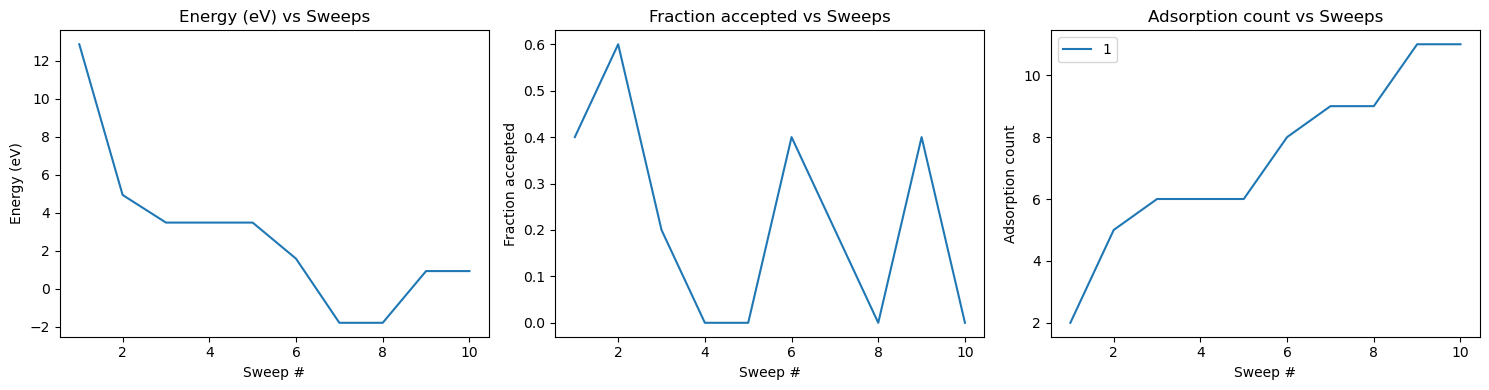

In [11]:
mcmc = MCMC(
    system_settings["surface_name"],
    calc=nff_surf_calc,
    canonical=False,
    testing=False,
    element=element,
    adsorbates=list(calc_settings["chem_pots"].keys()),
    relax=calc_settings["relax_atoms"],
    relax_steps=calc_settings["relax_steps"],
    offset=calc_settings["offset"],
    offset_data=calc_settings["offset_data"],
    optimizer=calc_settings["optimizer"],
)  # relax atoms with manual offset TODO fix this!

start = perf_counter()
# TODO: convert input to sampling settings
mcmc.mcmc_run(
    total_sweeps=sampling_settings["num_sweeps"],
    sweep_size=sampling_settings["sweep_size"],
    start_temp=sampling_settings["temperature"],
    pot=list(calc_settings["chem_pots"].values()),
    alpha=sampling_settings["alpha"],
    surface=surface,
)
stop = perf_counter()
print(f"Time taken = {stop - start} seconds")

Save structures for later use in latent space clustering or analysis

In [ ]:
structures = mcmc.history
with open("data/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)